# Establishing Pipelines

Now that I have the structure of the transformations that I am going to apply to the data, I will create pipelines to facilitate the processes

## Data separation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Read the data
route_employee_survey = '/content/drive/MyDrive/workplace-engineering-take-home-test-main/src/employee_survey_data.csv'
route_general_data = '/content/drive/MyDrive/workplace-engineering-take-home-test-main/src/general_data.csv'
route_manager_survey = '/content/drive/MyDrive/workplace-engineering-take-home-test-main/src/manager_survey_data.csv'
route_work_logs_data = '/content/drive/MyDrive/workplace-engineering-take-home-test-main/src/work_logs_data.csv'

employee_survey = pd.read_csv(route_employee_survey)
general_data = pd.read_csv(route_general_data)
manager_survey = pd.read_csv(route_manager_survey)
work_logs_data = pd.read_csv(route_work_logs_data, index_col="EmployeeID")

# Merge all data sources into one dataframe
data = employee_survey.merge(general_data, on='EmployeeID')
data = data.merge(manager_survey, on='EmployeeID')

# Drop rows with null values of attrition
data = data.dropna(subset=['Attrition']).set_index('EmployeeID')

# Separate target from predictors
y = data.Attrition
X = data.drop(['Attrition'], axis=1)

# Select numerical columns
columns_numerical = X.select_dtypes(include=[np.number]).columns

# Select categorical columns
columns_categorical = X.select_dtypes(include=["object"]).columns

# For Ordinal Encoding
columns_ordinal = ["BusinessTravel", "MaritalStatus", "Gender", "Over18"]

#For OneHot Encoding
columns_one_hot = columns_categorical.drop(columns_ordinal)

# Select numerical columns except TotalWorkingYears
data_int_cols = columns_numerical.drop("TotalWorkingYears")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

## Defining Preprocesing steps

### Numerical imputation

Creating a custom transformer for using with TotalWorkingYears column

In [ ]:
from sklearn.impute import SimpleImputer

class WorkingYearsTransformer:
    def __init__(self):
        self.gen_imputer = SimpleImputer(strategy='median')

    def fit(self, X, Y=None):
        self.gen_imputer.fit(X[data_int_cols])

        return self

    def transform(self, df):
        transformed_df = df.copy()

        transformed_df[data_int_cols] = self.gen_imputer.transform(df[data_int_cols])
        transformed_df.loc[transformed_df.TotalWorkingYears.isna(), "TotalWorkingYears"] = transformed_df.loc[transformed_df.TotalWorkingYears.isna(), "YearsAtCompany"]

        return transformed_df


numerical_transformer = WorkingYearsTransformer()

### Categorical imputation and encoding

In [ ]:
# Imputer for categorical columns

cat_imputer = SimpleImputer(strategy='most_frequent')

Preprocessing for categorical Ordinal data

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Encoder for marital and travel
ordinal_encoder_travel = OrdinalEncoder(
    categories=[np.array(['Non-Travel', 'Travel_Rarely', 'Travel_Frequently'])],
    handle_unknown='use_encoded_value',
    unknown_value=-1
    )
ordinal_encoder_marital = OrdinalEncoder(
    categories=[np.array(['Single', 'Married', 'Divorced'])],
    handle_unknown='use_encoded_value',
    unknown_value=-1
    )
ordinal_encoder_18 = OrdinalEncoder(
    categories=[np.array(['N', 'Y'])],
    handle_unknown='use_encoded_value',
    unknown_value=-1
    )

A custom transformer for ordinal categorical data to distinguish between the columns BusinessTravel and MaritalStatus

In [ ]:
class Categorical_Ordinal_Transformer:
    def __init__(self):
        self.temp_imputer = SimpleImputer(strategy='most_frequent')
        self.ordinal_encoder_travel = ordinal_encoder_travel
        self.ordinal_encoder_marital = ordinal_encoder_marital
        self.ordinal_encoder_gender = OrdinalEncoder()
        self.ordinal_encoder_18 = ordinal_encoder_18

    def fit(self, X, Y=None):
        imputed_X = X[columns_ordinal].copy()

        self.temp_imputer.fit(imputed_X)

        imputed_X.iloc[:, :] = self.temp_imputer.transform(imputed_X)

        self.ordinal_encoder_travel.fit(imputed_X[["BusinessTravel"]])
        self.ordinal_encoder_marital.fit(imputed_X[["MaritalStatus"]])
        self.ordinal_encoder_gender.fit(imputed_X[["Gender"]])
        self.ordinal_encoder_18.fit(imputed_X[["Over18"]])

        return self

    def transform(self, df):
        transformed_df = df[columns_ordinal].copy()

        transformed_df.iloc[:, :] = self.temp_imputer.transform(transformed_df)

        transformed_df.loc[:, "BusinessTravel"] = self.ordinal_encoder_travel.transform(transformed_df[["BusinessTravel"]])
        transformed_df.loc[:, "MaritalStatus"] = self.ordinal_encoder_marital.transform(transformed_df[["MaritalStatus"]])
        transformed_df.loc[:, "Gender"] = self.ordinal_encoder_gender.transform(transformed_df[["Gender"]])
        transformed_df.loc[:, "Over18"] = self.ordinal_encoder_18.transform(transformed_df[["Over18"]])

        return transformed_df


categorical_ordinal_transformer = Categorical_Ordinal_Transformer()

Preprocessing for categorical not Ordinal data

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

onehot_encoder = OneHotEncoder(
    handle_unknown='infrequent_if_exist',
    sparse_output=False,
    )

# Complete Pipeline
categorical_oneHot_transformer = Pipeline(steps=[
    ('imputer', cat_imputer),
    ('oneHot', onehot_encoder)
])

Ordinal and OneHot separation

Needed a custom transformer here to manage the loss of the columns for the inner transformer

In [ ]:
class Preprocesor_Transformer:
    def __init__(self):
        self.categorical_ordinal_transformer = categorical_ordinal_transformer
        self.categorical_oneHot_transformer = categorical_oneHot_transformer

    def fit(self, X, Y=None):
        ordinal_df = X[columns_ordinal]
        oneHot_df = X[columns_one_hot]

        self.categorical_ordinal_transformer = self.categorical_ordinal_transformer.fit(ordinal_df)
        self.categorical_oneHot_transformer = self.categorical_oneHot_transformer.fit(oneHot_df)

        return self

    def transform(self, df):
        transformed_df = df.copy()

        transformed_df.loc[:, columns_ordinal] = self.categorical_ordinal_transformer.transform(transformed_df[columns_ordinal])

        hot_encoded_data = self.categorical_oneHot_transformer.transform(transformed_df[columns_one_hot])
        hot_encoded_columns = categorical_oneHot_transformer.get_feature_names_out()

        hot_encoded_df = pd.DataFrame(hot_encoded_data, columns=hot_encoded_columns, index=transformed_df.index)

        transformed_df = pd.concat([transformed_df[columns_ordinal], hot_encoded_df], axis=1)

        return transformed_df


categorical_transformer = Preprocesor_Transformer()

### Categorical and Numerical separation

Same as before

In [ ]:
class Preprocesor_Transformer:
    def __init__(self):
        self.numerical_transformer = numerical_transformer
        self.categorical_transformer = categorical_transformer

    def fit(self, X, Y=None):
        num_df = X[columns_numerical]
        cat_df = X[columns_categorical]

        self.numerical_transformer = self.numerical_transformer.fit(num_df)
        self.categorical_transformer = self.categorical_transformer.fit(cat_df)

        return self

    def transform(self, df):
        num_vals = self.numerical_transformer.transform(df[columns_numerical])
        cat_vals = self.categorical_transformer.transform(df[columns_categorical])

        return np.concatenate((num_vals, cat_vals), axis=1)


preprocessor = Preprocesor_Transformer()

EmployeeCount, Over18 and StandardHours have a single value in all rows, so they are not valid columns for analysis or intelligent models.

# Correlation Matrix

In [ ]:
attrition_encoder = OrdinalEncoder(categories=[['No', 'Yes']])

y_encoded = pd.DataFrame(y.copy())
y_encoded["Attrition"] = attrition_encoder.fit_transform(y_encoded)

In [ ]:
categorical_transformer.fit(X[columns_categorical])
categorical_df = categorical_transformer.transform(X[columns_categorical])

numerical_transformer.fit(X[columns_numerical])
numerical_df = numerical_transformer.transform(X[columns_numerical])

In [ ]:
data_analysis = y_encoded.merge(numerical_df, on='EmployeeID')
data_analysis = data_analysis.merge(categorical_df, on='EmployeeID')
data_analysis = data_analysis.merge(work_logs_data, on='EmployeeID')

data_analysis = data_analysis.drop(['EmployeeCount', 'StandardHours', 'Over18'], axis=1)

data_analysis = data_analysis.drop(['DistanceFromHome', 'Education', 'JobLevel', 'StockOptionLevel', 'JobInvolvement'], axis=1)

data_analysis = data_analysis.drop(['JobRole_Laboratory Technician', 'EducationField_Marketing', 'EducationField_Medical',
                                    'JobRole_Healthcare Representative', 'JobRole_Human Resources', 'JobRole_Manager',
                                    'JobRole_Sales Executive', 'JobRole_Sales Representative', 'Gender', 'Department_Research & Development',
                                    'EducationField_Life Sciences'], axis=1)

In [ ]:
data_analysis.columns

Index(['Attrition', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'Age', 'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'PerformanceRating', 'BusinessTravel', 'MaritalStatus',
       'Department_Human Resources', 'Department_Sales',
       'EducationField_Human Resources', 'EducationField_Other',
       'EducationField_Technical Degree', 'JobRole_Manufacturing Director',
       'JobRole_Research Director', 'JobRole_Research Scientist',
       'PromHoursDay', 'PromHoursWeek', 'WorkingDaysOut'],
      dtype='object')

<Axes: >

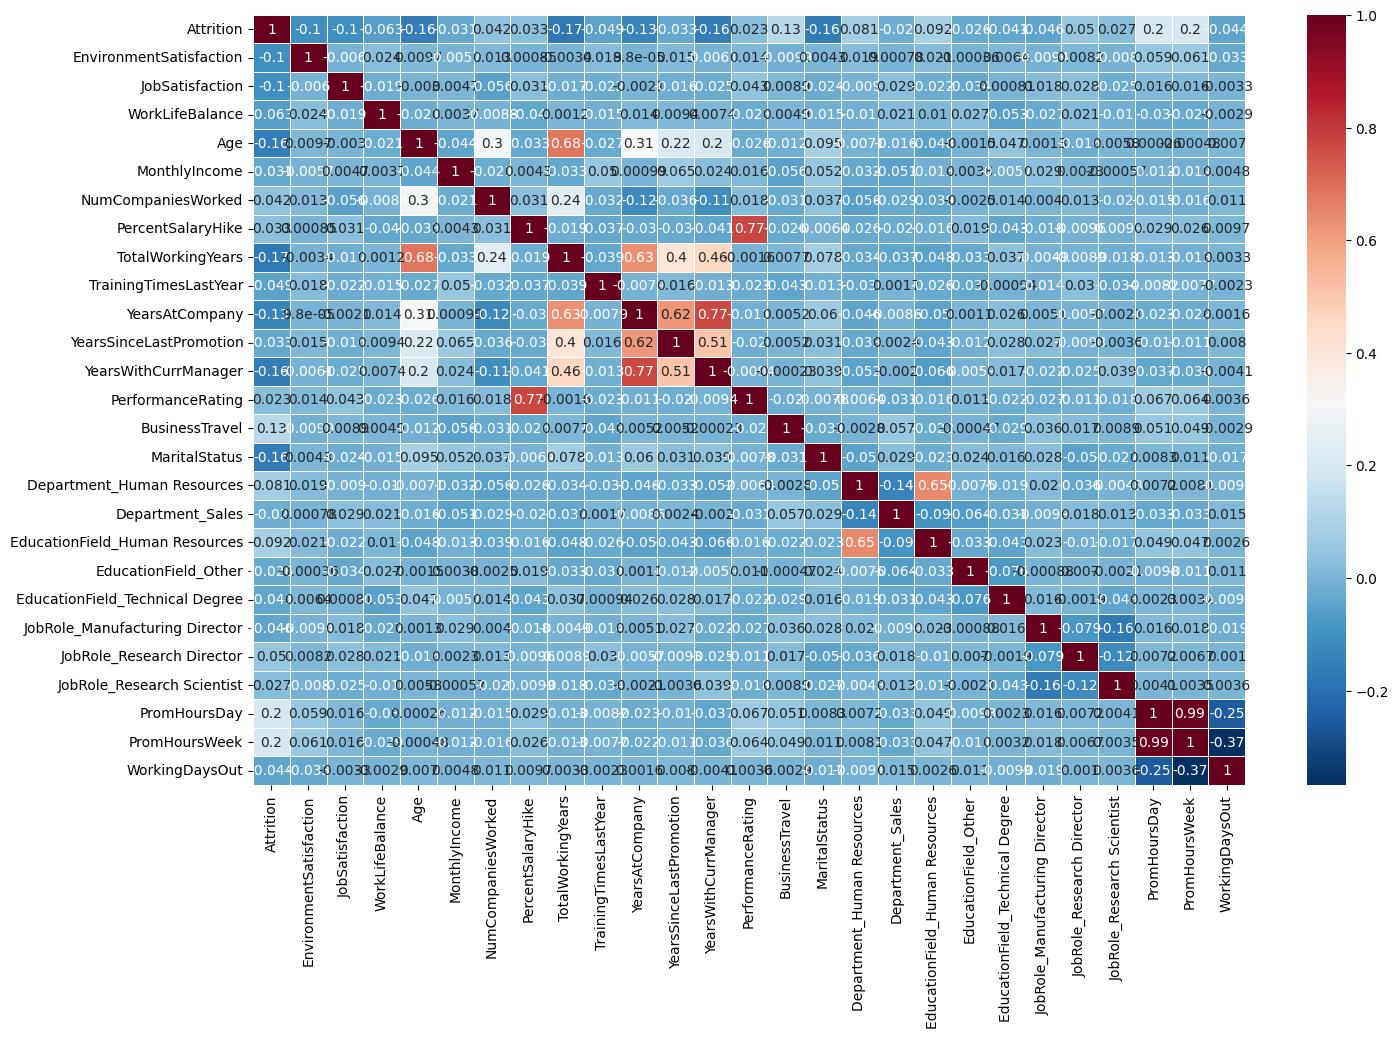

In [ ]:
pearson = data_analysis.corr(method='pearson')
pearson
plt.figure(figsize=(16, 10))
sns.heatmap(pearson,
            xticklabels=pearson.columns,
            yticklabels=pearson.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

The analysis shows that some variables have a high value of correlation between them, so I consider applying a dimensionality reduction to them, to reduce overfitting.

# Dimensionality Reduction

First of all, the PromHoursDay and PromHoursWeek columns have such a high correlation that I will keep only one of them, in this case PromHoursWeek.

In [ ]:
data_reduced = data_analysis.drop(['PromHoursDay'], axis=1)

### Principal Component Analysis (PCA):

I will use PCA as the dimensionality reduction method and StandardScaler to scale the values of the columns to be reduced.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()

A function to help with the reduction process

In [ ]:
def scaleAndReduce(df, columns, size, prefix):
  # Scales the data
  scaled_data = pd.DataFrame(scaler.fit_transform(df[columns]))

  # Apply dimensionality reduction
  pca = PCA(n_components = size)
  pca.fit(scaled_data)
  data_pca = pca.transform(scaled_data)

  # Creates names for the new columns
  new_columns = []
  for i in range(size):
    new_columns.append(prefix + f"_{i}")

  # Creates a dataframe with the new columns with reduced dimensionality
  data_pca = pd.DataFrame(data_pca,columns=new_columns, index=df.index)

  # Drop the original columns
  df_new = df.drop(columns, axis=1)

  # Merge the new columns with the original dataframe
  return df_new.merge(data_pca, on="EmployeeID")

Next I will group columns with a correlation factor greater than 0.5 to reduce their dimensionality.

#### PerformanceRating and PercentSalaryHike

In [ ]:
columns = ["PerformanceRating", "PercentSalaryHike"]
size = 1
prefix = "PC_0"

data_reduced = scaleAndReduce(data_reduced, columns, size, prefix)

#### TotalWorkingYears, YearsAtCompany, YearsSinceLastPromotion, YearsWithCurrManager and Age

In [ ]:
columns = ["TotalWorkingYears", "YearsAtCompany", "YearsSinceLastPromotion", "YearsWithCurrManager", "Age"]
size = 4
prefix = "PC_1"

data_reduced = scaleAndReduce(data_reduced, columns, size, prefix)

#### Department_Human Resources and EducationField_Human Resources

In [ ]:
columns = ["Department_Human Resources", "EducationField_Human Resources"]
size = 1
prefix = "PC_2"

data_reduced = scaleAndReduce(data_reduced, columns, size, prefix)

### New Correlation Matrix

<Axes: >

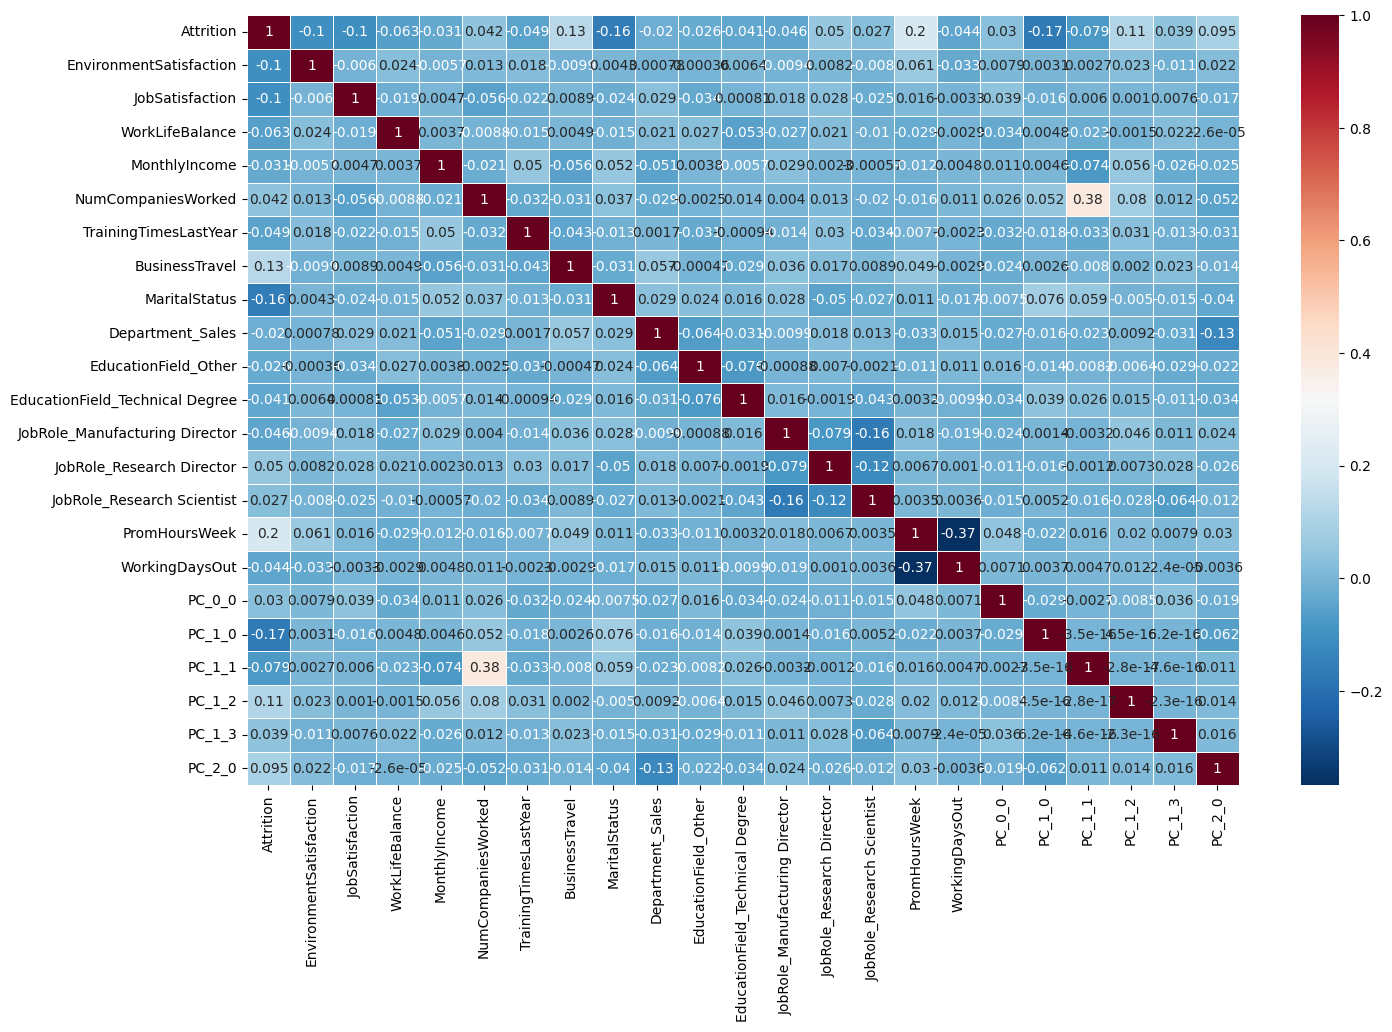

In [ ]:
pearson2 = data_reduced.corr(method='pearson')
plt.figure(figsize=(16, 10))
sns.heatmap(pearson2,
            xticklabels=pearson2.columns,
            yticklabels=pearson2.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

The new correlation matrix shows how all columns have a factor of less than 0.4, which will help to avoid overfitting.